# Paper figures 
## A general polarimetric model for transiting and non-transiting ringed exoplanets

This notebook uses `Pryngles` to calculate and generate the figures of the paper:

> A general polarimetric model for transiting and non-transiting ringed exoplanets, Allard. K. Veenstra, Jorge I. Zuluaga, Jaime A. Alvarado-Montes, Mario Sucerquia and Daphne M. Stam (submitted).

## Preliminary

### Required packages

You will need to install the following packages that are not installed with `Pryngles`:

- OpenCV.
- gdown.

If you are in a Linux environmente just run:

In [121]:
!pip install -q opencv-python gdown

Pryngles pakages and modules:

In [11]:
%load_ext autoreload
%autoreload 2
import pryngles as pr
from pryngles import Consts
extension = 'cpixx'
print(f"Pryngles version: {pr.version}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Pryngles version: 0.9.5


Import dependencies

In [574]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import multiprocessing as mp
from joblib import Parallel,delayed,cpu_count
import math
import time
import cv2 as cv
import pickle
from tqdm import tqdm
from sys import stdout
mpl.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 15})

### Configuration

In order to run this scripts is better to have directories for the temporary files and figure files. If you are in Linux use the following cell, otherwise create manually the directories:

In [103]:
!mkdir -p tmp/ figures/

You may change the directory names:

In [101]:
tmp_dir="tmp/"
fig_dir="figures/"

### Get the required data

`Pryngles` has a public Google Drive repo with data useful for calculations. This the repo: https://bit.ly/pryngles-data. You may obtain the data by yourself or retrieve it using the corresponding `Misc` routine. The last one is the more appropiate method since only the name of the file need to be provided:

In [105]:
files=["fou_ring_0_4_0_8.dat","fou_bmsca60.0_asurf1.0.dat"]
pr.Misc.retrieve(files,path=tmp_dir,overwrite=False,quiet=False)

Downloading...
From: https://docs.google.com/feeds/download/spreadsheets/Export?exportFormat=xlsx&key=17rgmzuENn_5jEO2rzDzngJLpZT1P9rPsQr3PNQGFkGs
To: /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/doc/papers/full-scattering/tmp/pryngles_files_index.xlsx
31.2kB [00:00, 1.04MB/s]


There are 18 files in data repository.


Downloading...
From: https://docs.google.com/uc?export=download&id=1G_QUlPqyMb0Te3YthH5EqKweSHBJt7MJ
To: /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/doc/papers/full-scattering/tmp/fou_ring_0_4_0_8.dat
100%|██████████| 64.9M/64.9M [00:17<00:00, 3.78MB/s]

File tmp//fou_bmsca60.0_asurf1.0.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_0_4_0_8.dat', 'tmp//fou_bmsca60.0_asurf1.0.dat']


['tmp//fou_ring_0_4_0_8.dat', 'tmp//fou_bmsca60.0_asurf1.0.dat']

### Useful routines

Some task are too complex to include along the code, therefore we pack it into useful routines:

In [548]:
def pool_handler(loc_num, params, func, multiplier,max_process=None):
    
    if max_process is None:
        max_process = math.floor(mp.cpu_count()*multiplier)
    
    # Max allowed thread count on the server is 14
    if max_process>14: max_process=14
    
    if loc_num > max_process:
        run_num = 0
        while loc_num > 0:
            lbound = run_num*max_process
            if loc_num > max_process: ubound = (run_num+1)*max_process
            else: ubound = lbound + loc_num
            processes = [mp.Process(target=func, args=(params[i]))
                        for i in range(lbound, ubound)]
            for p in processes:
                time.sleep(0.1)
                p.start()
            for p in processes:
                time.sleep(0.1)
                p.join()
            loc_num = loc_num - max_process
            run_num+=1
    else:
        processes = [mp.Process(target=func, args=(params[i]))
                    for i in range(0, loc_num)]
        for p in processes:
            time.sleep(0.1)
            p.start()
        for p in processes:
            time.sleep(0.1)
            p.join()

def setup_plot(ax,maticksizex,xlim0,xlim1,maticksizey,ylim0,ylim1,notext=False):  
    ax.xaxis.set_major_locator(ticker.MultipleLocator(maticksizex))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(maticksizey))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    if notext:
        ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
    ax.tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)
    ax.set_xlim([xlim0,xlim1])
    ax.set_ylim([ylim0,ylim1])
    ax.patch.set_alpha(0.0)
    
def add_subplot_axes(ax,rect,facecolor='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

def hprint(*args):
    logfile=args[0]
    msg="\n".join([str(arg) for arg in args[1:]])+"\n"
    logfile.write(msg)
    logfile.flush()

def save_figure(fig, fig_name, fig_dir='/tmp', dpi=600, formats=['png','svg','eps'],quiet=False,**options):
    for form in formats:
        fig_file = fig_dir + fig_name + '.' + form
        if not quiet:
            print(f"Saving {fig_file}...")
        fig.savefig(fig_file,format=form,dpi=dpi,bbox_inches='tight',**options)

## Figure 1, planet at different positions in its orbit

The original reference system of `Pryngles` is planet-centered. However, sometimes it is more convenient indicate the orientation of the ring with respect to the observer or the plane of the Sky (see Figure below).
<img src="https://drive.google.com/uc?export=view&id=17PeO_jEK9nSv-E8ZmXxVW-1h8PxsLiS_" width=400>

In [592]:
# Global configuration of the system
gamma = 60.0 # Ring inclination, 90 is edge-on, 0 is face-on 
iorb = 70.0 # Orbit inclination, 90 is edge-on, 0 is face-on 
alphar = 0.0 # Ring roll angle 

# Calculate planet-centered conditions
ir, beta_obs, lamb_obs, lamb_star = pr.Util.calcStartingPosition(iorb, gamma, alphar)

print(f"Initial conditions in the planet-centered system are:")
print(f"\tRing inclination w.r.t. ecliptic: {ir*Consts.rad:.1f} deg")
print(f"\tInclination of the observer w.r.t ecliptic: {beta_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the observer: {lamb_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the star: {lamb_star*Consts.rad:.1f} deg")

Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 10.0 deg
	Inclination of the observer w.r.t ecliptic: 20.0 deg
	Initial longitude of the observer: 90.0 deg
	Initial longitude of the star: -90.0 deg


Create the system

In [593]:
sys = pr.System()

s=sys.add(kind="Star",
          physics=dict(radius=Consts.rsun/sys.ul),
          optics=dict(limb_coeffs=[0.65]))

p=sys.add(kind="Planet", primary=s, 
          radius=Consts.rsaturn/sys.ul,
          orbit=dict(a=1, e=0.0),
          physics=dict(radius=Consts.rsaturn/sys.ul),
          optics=dict(nspangles=10000))

r=sys.add(kind="Ring", primary=p,
          physics=dict(fi=1.2, fe=2.25, i=ir),
          optics=dict(nspangles=10000))

RP=sys.ensamble_system(extension=extension,
                       fname_planet=tmp_dir+'fou_bmsca60.0_asurf1.0.dat',
                       fname_ring=tmp_dir+'fou_ring_0_4_0_8.dat')

Create individual snapshots of the planet around the orbit:

In [594]:
lamb_initial = lamb_star
lamb_final = lamb_initial + 360*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,9)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP.updateSpangles()

for lamb in lambs:
    RP.changeStellarPosition(lamb)
    RP.updateSpangles()
    RP.updateReflection()

    print(f"Saving snapshots at true anomaly: {(lamb-lamb_initial)*Consts.rad}")
    ecl_fig,obs_fig,star_fig = RP.plotRingedPlanet(showstar=False,showfig=False,showtitle=False,axis=False)
    ecl_fig.savefig(fig_dir + f"fig_at_{int((lamb-lamb_initial)*Consts.rad)}_ecl.png", dpi=500)
    obs_fig.savefig(fig_dir + f"fig_at_{int((lamb-lamb_initial)*Consts.rad)}_obs.png", dpi=500)
    star_fig.savefig(fig_dir + f"fig_at_{int((lamb-lamb_initial)*Consts.rad)}_star.png", dpi=500)
    plt.close()

Saving snapshots at true anomaly: 0.0
Saving snapshots at true anomaly: 45.0
Saving snapshots at true anomaly: 90.0
Saving snapshots at true anomaly: 135.0
Saving snapshots at true anomaly: 180.0
Saving snapshots at true anomaly: 225.0
Saving snapshots at true anomaly: 270.0
Saving snapshots at true anomaly: 315.0
Saving snapshots at true anomaly: 360.0


Now we can compose the configuration image:

<IPython.core.display.Javascript object>


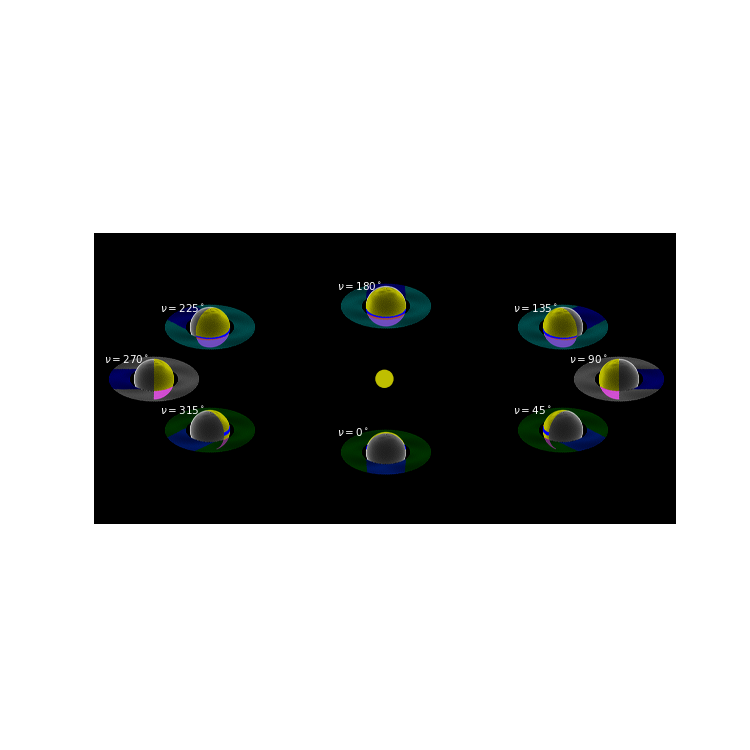

Introducing image 0 corresponging to longitude 0...
Introducing image 1 corresponging to longitude 45...
Introducing image 2 corresponging to longitude 90...
Introducing image 3 corresponging to longitude 135...
Introducing image 4 corresponging to longitude 180...
Introducing image 5 corresponging to longitude 225...
Introducing image 6 corresponging to longitude 270...
Introducing image 7 corresponging to longitude 315...
Saving figure...
Saving figures/Diff_positions_new.png...
Saving figures/Diff_positions_new.svg...
Saving figures/Diff_positions_new.eps...


In [595]:
# Coordinates for the location of the images and labels
def loc_func(phi,a,b):
    x = a*np.cos(phi)+0.5
    y = b*np.sin(phi)+0.5
    return x,y

# Locations
lambs = np.array([0,45,90,135,180,225,270,315])
names=[]
for lamb in lambs:
    names+=[f"$\nu={lamb:d} \degree$"]

# Insert image properties
ratio = np.sin(np.pi/2 - 60*np.pi/180)
xpixels = 5000
ypixels = int(xpixels*ratio)
img = np.zeros((ypixels,xpixels))

# Axis sizes
ysize = 0.4*ratio
xsize = 0.4

# Convert to 3 channel black (color)
img = cv.merge([img,img,img])

# Location of subplot
phi = np.linspace(-np.pi/2,3/2*np.pi,9)
a = 0.5
b = 0.5*ratio
xloc,yloc = loc_func(phi,a,b)

# Offset
eqv75 = 0.75#1-np.sin(45*np.pi/180)/2
eqv25 = 0.25#np.sin(45*np.pi/180)/2

xoffset = np.array([0.5*ysize,eqv75*ysize,ysize,eqv75*ysize,0.5*ysize,
                    eqv25*ysize,0,eqv25*ysize])
yoffset = np.array([xsize,eqv25*xsize,0.5*xsize,eqv75*xsize,0,eqv75*xsize,
                    0.5*xsize,eqv25*xsize])
sub_plot_locx = xloc[:-1]-xoffset
sub_plot_locy = yloc[:-1]-xsize*0.5#yoffset

#Create figure
fsize = 1 # Use 5 for paper purposes
fig = plt.figure(figsize=(5*fsize,5*fsize))
gs = fig.add_gridspec(1)
axs = gs.subplots(sharex=False)
axs.imshow(img)
star = plt.Circle((2500, 2500*(ratio)), 70, color='y')
axs.add_patch(star)

for ii,lamb in enumerate(lambs):
    print(f"Introducing image {ii} corresponging to longitude {lamb}...")
    figure_loc = fig_dir + f"fig_at_{lamb}_obs.png"
    figure = cv.imread(figure_loc)

    subpos = [sub_plot_locx[ii],sub_plot_locy[ii],ysize,xsize]
    subax1 = add_subplot_axes(axs,subpos)

    b, g, r = cv.split(figure)
    tmp = cv.cvtColor(figure, cv.COLOR_BGR2GRAY)
    _,alp = cv.threshold(tmp,0,255,cv.THRESH_BINARY)
    rgba = [r,g,b, alp]
    figure_crop = cv.merge(rgba,4)
    scale = 6/9 #5/9
    width = int(figure_crop.shape[1] * scale)
    height = int(figure_crop.shape[0] * scale)
    dim = (width,height)
    resized = cv.resize(figure_crop, dim, interpolation = cv.INTER_AREA)
    subax1.imshow(resized, interpolation='spline36', aspect='auto')
    subax1.text(0.09, 0.67, f"$\\nu={lamb}^\circ$", 
                {'fontsize': 5*fsize}, horizontalalignment='left',
                verticalalignment='center', transform=subax1.transAxes,color="w")
    subax1.set_axis_off()
    
axs.set_axis_off()
print("Saving figure...")
save_figure(fig, "Diff_positions_new", fig_dir=fig_dir, dpi=600)

## Figure 4: Phase function

Get datafiles required:

In [214]:
files=["s5.sc.F.dat", "20mu_4500_1.5.dat","40mu_4500_1.5.dat"]
pr.Misc.retrieve(files,path=tmp_dir,overwrite=True,quiet=False)

Downloading...
From: https://docs.google.com/feeds/download/spreadsheets/Export?exportFormat=xlsx&key=17rgmzuENn_5jEO2rzDzngJLpZT1P9rPsQr3PNQGFkGs
To: /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/doc/papers/full-scattering/tmp/pryngles_data_index.xlsx
37.8kB [00:00, 902kB/s]


There are 138 files in data repository.


Downloading...
From: https://docs.google.com/uc?export=download&id=13mbztSDFO-7nWuH0akTCkpMZAW6GbGPq
To: /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/doc/papers/full-scattering/tmp/s5.sc.F.dat
100%|██████████| 429k/429k [00:00<00:00, 1.25MB/s]
Downloading...
From: https://docs.google.com/uc?export=download&id=1Z4wzls1Cdr2tQB226oVbJ4Xm5p0oDXUV
To: /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/doc/papers/full-scattering/tmp/20mu_4500_1.5.dat
100%|██████████| 429k/429k [00:00<00:00, 1.12MB/s]
Downloading...
From: https://docs.google.com/uc?export=download&id=1-04pZxJgfR5zxYHcaCODzrMfkrIocDfE
To: /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/doc/papers/full-scattering/tmp/40mu_4500_1.5.dat
100%|██████████| 429k/429k [00:00<00:00, 1.11MB/s]

Files downloaded: ['tmp//s5.sc.F.dat', 'tmp//20mu_4500_1.5.dat', 'tmp//40mu_4500_1.5.dat']


['tmp//s5.sc.F.dat', 'tmp//20mu_4500_1.5.dat', 'tmp//40mu_4500_1.5.dat']

Now we will plot the phase functions contained in the matrices:

<IPython.core.display.Javascript object>


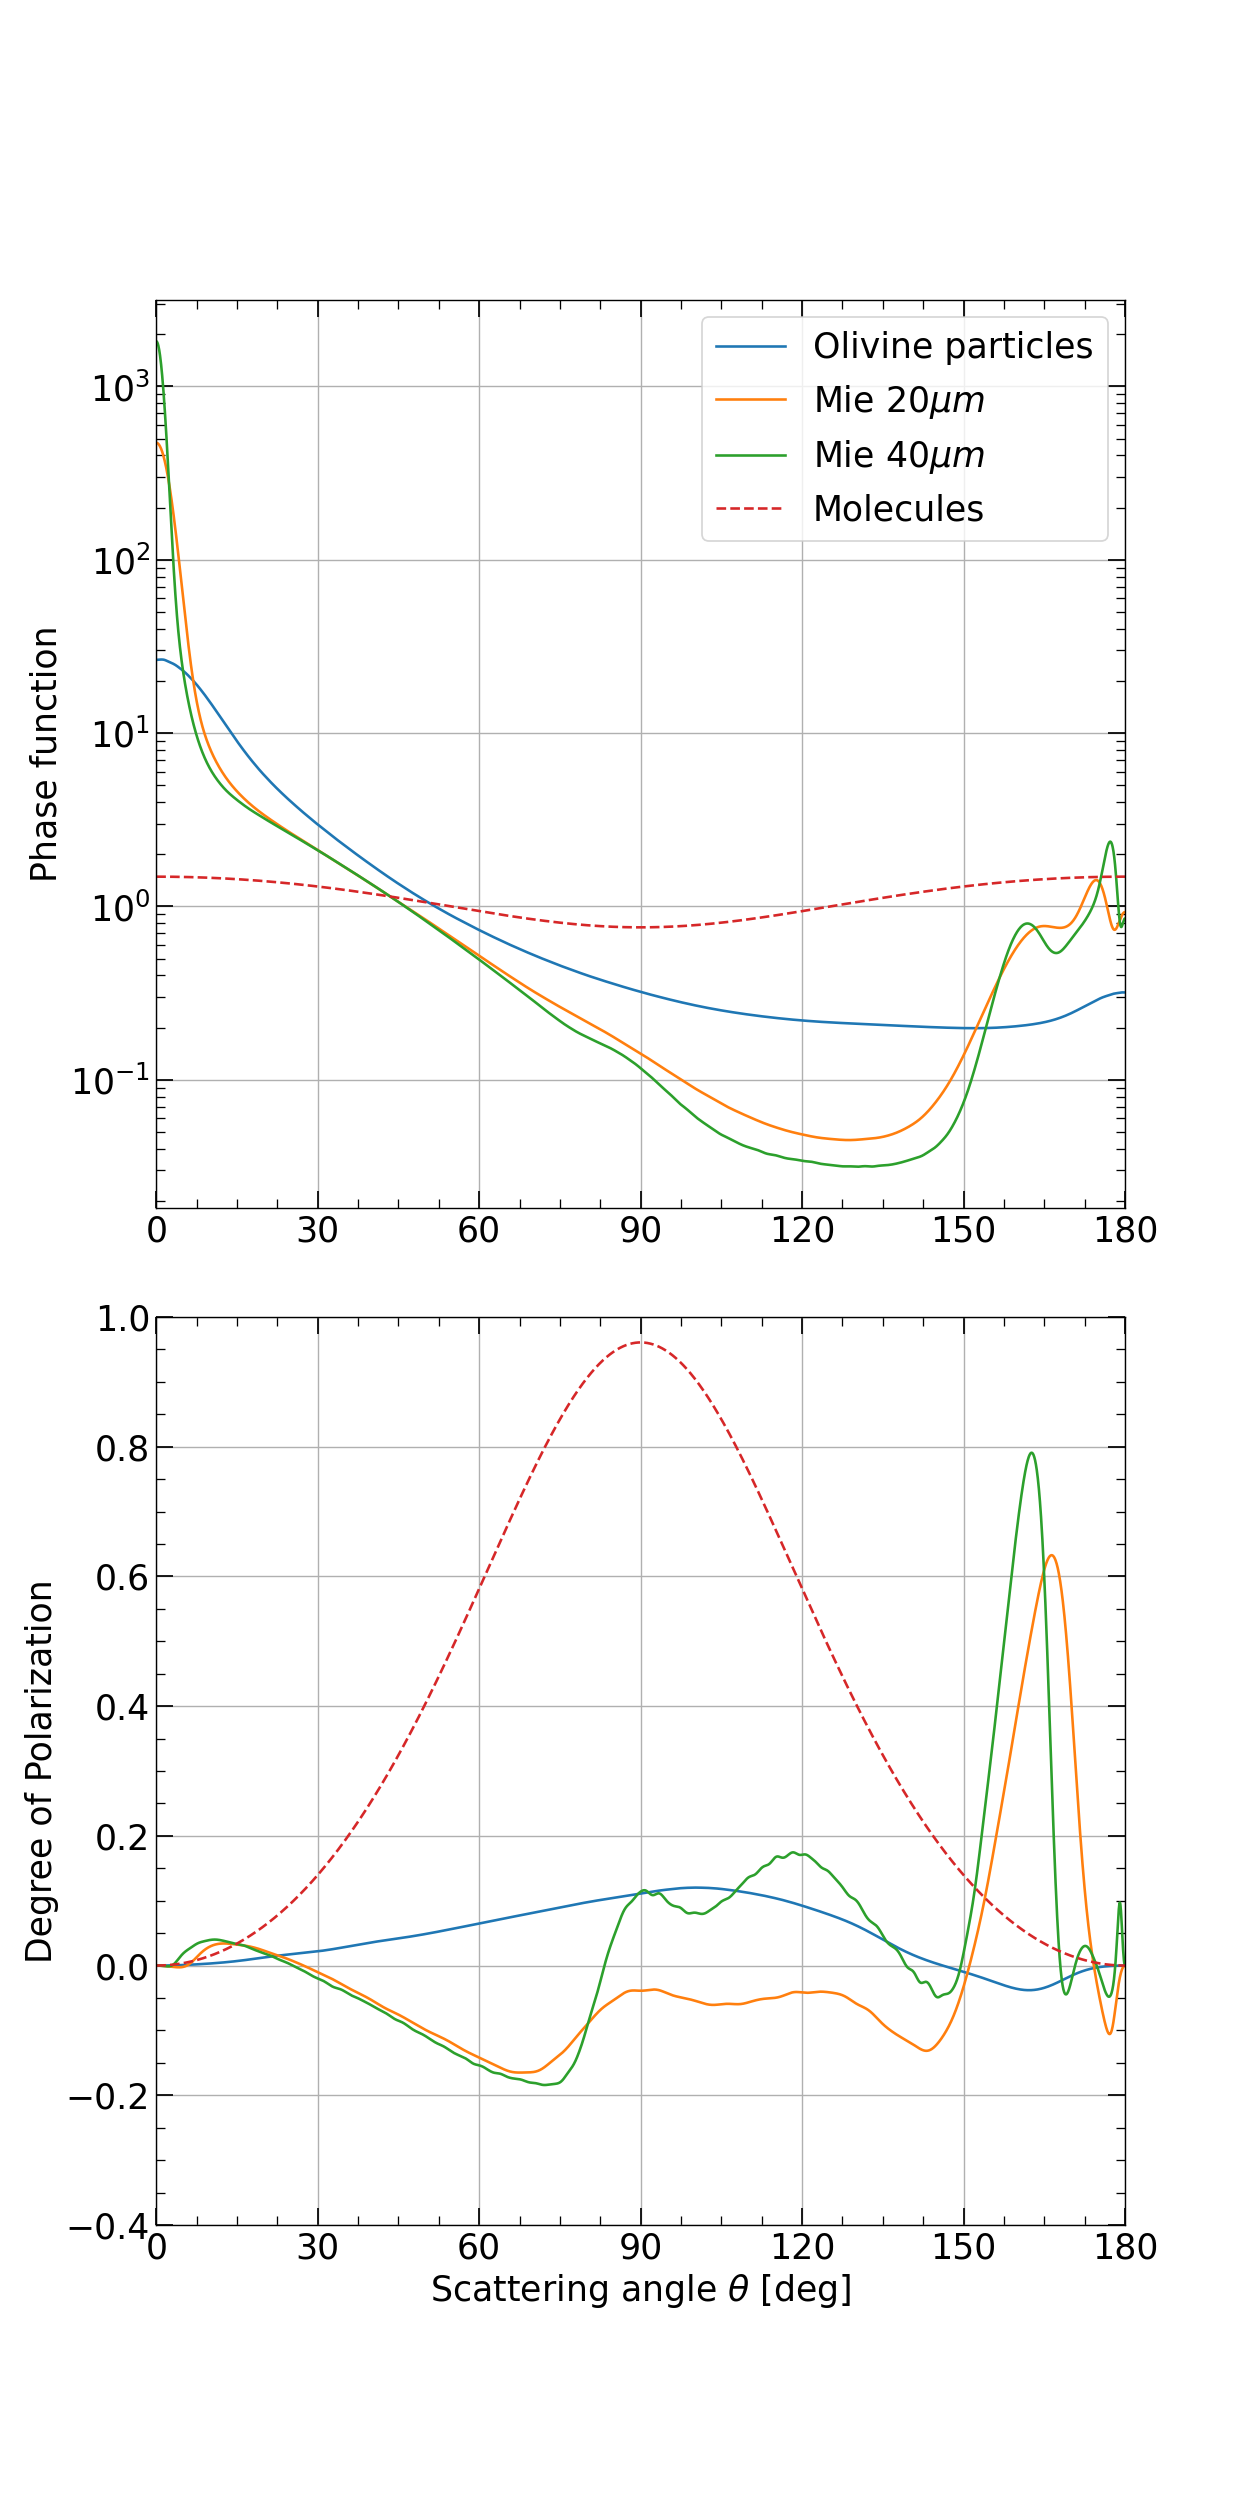

Saving figures/single_scattering_incl_mie20_and_40.png...
Saving figures/single_scattering_incl_mie20_and_40.svg...
Saving figures/single_scattering_incl_mie20_and_40.eps...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [240]:
def gas_FandP(alpha,sigma):
    delta  = (1-sigma)/(1+sigma/2)
    deltal = (1-2*sigma)/(1-sigma)
    F11 = delta*(3/4)*(1+np.cos(alpha)**2)+(1-delta)
    P = np.sin(alpha)**2/(1+np.cos(alpha)**2 + 2*sigma/(1-sigma))
    return F11,P

names = ["s5.sc.F.dat", "20mu_4500_1.5.dat","40mu_4500_1.5.dat"]
plot_names = np.array(["Olivine particles", "Mie $20 \mu m$", "Mie $40 \mu m$"])

fsize=2
fig = plt.figure(figsize=(5*fsize,10*fsize))
gs = fig.add_gridspec(2,1, hspace=0.12)
ax = gs.subplots(sharex=False)
plt.rcParams.update({'font.size': 10*fsize})

for ii,name in enumerate(names):
    scattering_matrix_name = tmp_dir + name
    angle = []
    F11   = []
    F22   = []
    F33   = []
    F44   = []
    F12   = []
    F34   = []
    POL   = []

    for line in open(scattering_matrix_name).readlines():
        sp = line.split()
        angle += [float(sp[0])]
        F11   += [float(sp[1])]
        F22   += [float(sp[2])]
        F33   += [float(sp[3])]
        F44   += [float(sp[4])]
        F12   += [float(sp[5])]
        F34   += [float(sp[6])]
        POL   += [float(sp[7])]

    df = pd.DataFrame({"Angle": angle, "F11": F11, "F22": F22, "F33": F33,
                       "F44": F44, "F12": F12, "F34": F34, "POL": POL})

    ax[0].plot(df["Angle"], df["F11"],label=plot_names[ii])
    ax[1].plot(df["Angle"], df["POL"], label=plot_names[ii])

# Gas particles phase function
theta = np.linspace(0,np.pi,10000)
sigma = 0.02
F11,P = gas_FandP(theta,sigma)
ax[0].plot(theta*180/np.pi,F11,"--",label="Molecules")
ax[1].plot(theta*180/np.pi,P,"--",label="Molecules")

ax[0].set_ylabel("Phase function")
ax[0].set_yscale("log")
ax[0].legend()
ax[0].grid()
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(30))
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].set_xlim([0,180])
setup_plot(ax[1],30,0,180,0.2,-0.4,1.0,notext=False)
ax[0].tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
ax[0].tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)

ax[1].set_ylabel("Degree of Polarization")
ax[1].set_xlabel("Scattering angle $\\theta$ [deg]")
ax[1].grid()
ax[1].tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
ax[1].tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)

save_figure(fig,"single_scattering_incl_mie20_and_40",fig_dir,dpi=600)

Only two of them:

<IPython.core.display.Javascript object>


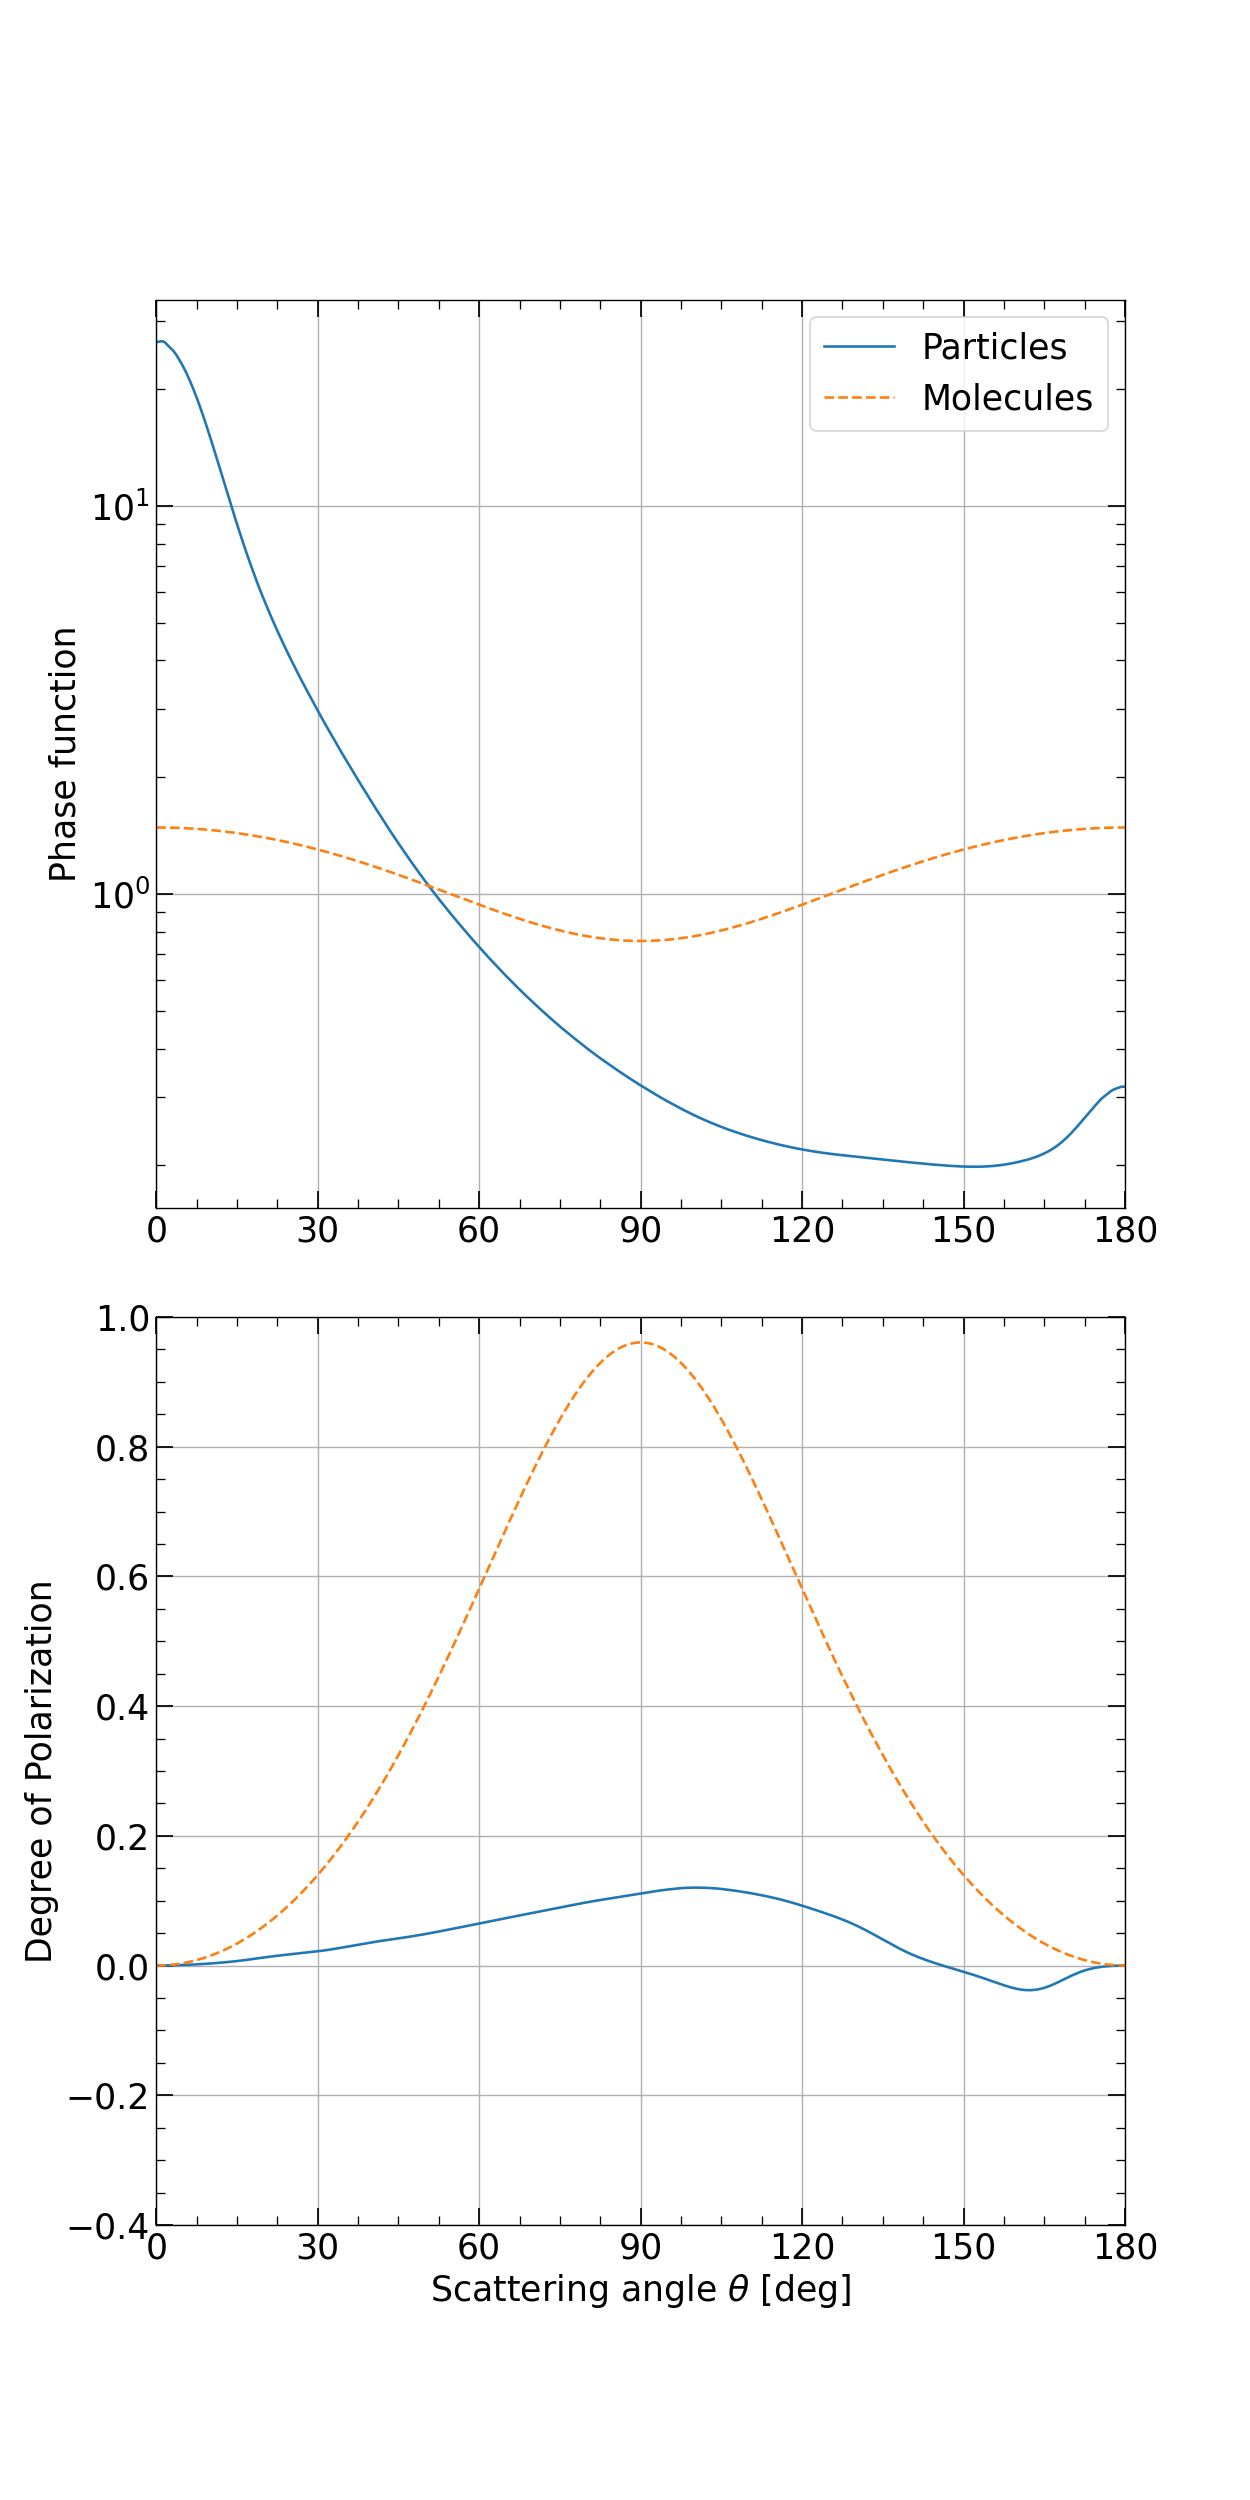

Saving figures/single_scattering.png...
Saving figures/single_scattering.svg...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving figures/single_scattering.eps...


In [244]:
def gas_FandP(alpha,sigma):
    delta  = (1-sigma)/(1+sigma/2)
    deltal = (1-2*sigma)/(1-sigma)
    F11 = delta*(3/4)*(1+np.cos(alpha)**2)+(1-delta)
    P = np.sin(alpha)**2/(1+np.cos(alpha)**2 + 2*sigma/(1-sigma))
    return F11,P

names = ["s5.sc.F.dat"]
plot_names = np.array(["Particles"])

fsize=2
fig = plt.figure(figsize=(5*fsize,10*fsize))
gs = fig.add_gridspec(2,1, hspace=0.12)
ax = gs.subplots(sharex=False)
plt.rcParams.update({'font.size': 10*fsize})

for ii,name in enumerate(names):
    scattering_matrix_name = tmp_dir + name
    angle = []
    F11   = []
    F22   = []
    F33   = []
    F44   = []
    F12   = []
    F34   = []
    POL   = []

    for line in open(scattering_matrix_name).readlines():
        sp = line.split()
        angle += [float(sp[0])]
        F11   += [float(sp[1])]
        F22   += [float(sp[2])]
        F33   += [float(sp[3])]
        F44   += [float(sp[4])]
        F12   += [float(sp[5])]
        F34   += [float(sp[6])]
        POL   += [float(sp[7])]

    df = pd.DataFrame({"Angle": angle, "F11": F11, "F22": F22, "F33": F33,
                       "F44": F44, "F12": F12, "F34": F34, "POL": POL})

    ax[0].plot(df["Angle"], df["F11"],label=plot_names[ii])
    ax[1].plot(df["Angle"], df["POL"], label=plot_names[ii])

# Gas particles phase function
theta = np.linspace(0,np.pi,10000)
sigma = 0.02
F11,P = gas_FandP(theta,sigma)
ax[0].plot(theta*180/np.pi,F11,"--",label="Molecules")
ax[1].plot(theta*180/np.pi,P,"--",label="Molecules")

ax[0].set_ylabel("Phase function")
ax[0].set_yscale("log")
ax[0].legend()
ax[0].grid()
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(30))
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].set_xlim([0,180])
setup_plot(ax[1],30,0,180,0.2,-0.4,1.0,notext=False)
ax[0].tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
ax[0].tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)

ax[1].set_ylabel("Degree of Polarization")
ax[1].set_xlabel("Scattering angle $\\theta$ [deg]")
ax[1].grid()
ax[1].tick_params(which='major', direction='in', length=10, width=1.00, right=True, top=True)
ax[1].tick_params(which='minor', direction='in', length=5, width=0.75, right=True, top=True)

save_figure(fig,"single_scattering",fig_dir,dpi=600)

## Figure 5: ring-less planet

Let's see how a ring-less planet reflect light:

Get datafiles required:

In [245]:
files=["fou_ring_0_4_0_8.dat","fou_bmsca10.0_asurf0.5.dat"]
pr.Misc.retrieve(files,path=tmp_dir,overwrite=False,quiet=False)

Index file tmp//pryngles_data_index.xlsx already retrieved. For overwrite use overwrite = True.
There are 138 files in data repository.
File tmp//fou_ring_0_4_0_8.dat already retrieved. For overwrite use overwrite = True.


Downloading...
From: https://docs.google.com/uc?export=download&id=1fq8djsdNl6JWq-bI2YDTKszcSuwcYnw1
To: /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/doc/papers/full-scattering/tmp/fou_bmsca10.0_asurf0.5.dat
100%|██████████| 342k/342k [00:00<00:00, 852kB/s]

Files downloaded: ['tmp//fou_ring_0_4_0_8.dat', 'tmp//fou_bmsca10.0_asurf0.5.dat']


['tmp//fou_ring_0_4_0_8.dat', 'tmp//fou_bmsca10.0_asurf0.5.dat']

These are the parameter for our numerical experiment:

In [419]:
fou_file_ring = tmp_dir + "fou_ring_0_4_0_8.dat"
fou_file_planet = tmp_dir + "fou_bmsca10.0_asurf0.5.dat"

# Range of orbital inclinations to explore
iorbs = np.array([0,10,20,30,40,50,60,70,80,90]) # 

# Though ring is transparent we must provide options
tau_ring = 0.0 # Ring is transparent
ring_ri = 2.0
ring_re = 2.25
gamma = 80 # Ring inclination
alphar = 0 # Ring roll

# Scattering options
interp = "spline"
reference_plane = "Detector"

# Number of spangles
Ns = 30
Nb = 0
Np = 12000
Nr = 100

Let's run a single simulation:

In [421]:
# Make sure all output is printed
pr.Verbose.VERBOSITY=pr.VERB_NONE
iorb = iorbs[2]
value = iorb

# Calculate starting position of observer and star
ir, beta_obs, lamb_obs, lamb_star = pr.Util.calcStartingPosition(iorb,gamma,alphar)
print(f"Initial conditions in the planet-centered system are:")
print(f"\tRing inclination w.r.t. ecliptic: {ir*Consts.rad:.1f} deg")
print(f"\tInclination of the observer w.r.t ecliptic: {beta_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the observer: {lamb_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the star: {lamb_star*Consts.rad:.1f} deg")

Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: -60.0 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: 90.0 deg
	Initial longitude of the star: -90.0 deg


Constant parameters:

In [422]:
a = 1
r_s = Consts.rsun
r_p = Consts.rsaturn
e = 0.0
theta_end = 360
n_theta = 361
allow_non_uni = False
normalize = True
lambq_offset = 0.0
limb_coeffs = [0.65]
interpr = "spline"
name = f"Orbit_incl80_fix"

Intialize system:

In [423]:
sys = pr.System()
s=sys.add(kind="Star",physics=dict(radius=r_s/sys.ul),optics=dict(limb_coeffs=limb_coeffs))
p=sys.add(kind="Planet", primary=s,
               radius=r_p/sys.ul,
               orbit=dict(a=a, e=e),
               physics=dict(radius=r_p/sys.ul),
               optics=dict(nspangles=Np))
r=sys.add(kind="Ring", primary=p,
               physics=dict(fi=ring_ri, fe=ring_re, i=ir),
               optics=dict(nspangles=Nr))

RP=sys.ensamble_system(extension=extension,
                       fname_planet=fou_file_planet,
                       fname_ring=fou_file_ring)
RP.behavior["interp_method_ring"] = interpr
RP.behavior["allow_non_uni"] = allow_non_uni
RP.reference_plane = reference_plane

Now we will prepare the interval of longitudes and see the configuration:

In [425]:
lamb_initial = lamb_star
lamb_final = lamb_initial + theta_end*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,n_theta)

# Determine starting position in eccentric orbit, default is apocenter
if e >= 0.05:
    lq = np.linspace(0,2*np.pi,2000)
    d_max = 0
    lambq_max = 0
    for ii,l in enumerate(lq):
        RP.lambq = l
        RP.changeStellarPosition(lamb_initial)
        d = RP.rstar
        if d >= d_max:
            d_max = d
            lambq_max = l
    RP.lambq = lambq_max + lambq_offset*np.pi/180     

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP.updateSpangles()

# Save images showing the starting position of planet, ring and star
ecl_fig,obs_fig,star_fig = RP.plotRingedPlanet(showstar=True,showfig=False)
for rf in "ecl","obs","star":
    fig=eval(f"{rf}_fig")
    save_figure(fig,f"fig_with_{name}_{value}_and_oi_{iorb}_rl_{alphar}_ri_{gamma}_rin_{ring_ri}_rout_{ring_re}_{rf}",
                fig_dir=fig_dir, dpi=300, formats=["png"])

Saving figures/fig_with_Orbit_incl80_fix_20_and_oi_20_rl_0_ri_80_rin_2.0_rout_2.25_ecl.png...
Saving figures/fig_with_Orbit_incl80_fix_20_and_oi_20_rl_0_ri_80_rin_2.0_rout_2.25_obs.png...
Saving figures/fig_with_Orbit_incl80_fix_20_and_oi_20_rl_0_ri_80_rin_2.0_rout_2.25_star.png...


Let's preview the configuration:

<IPython.core.display.Javascript object>


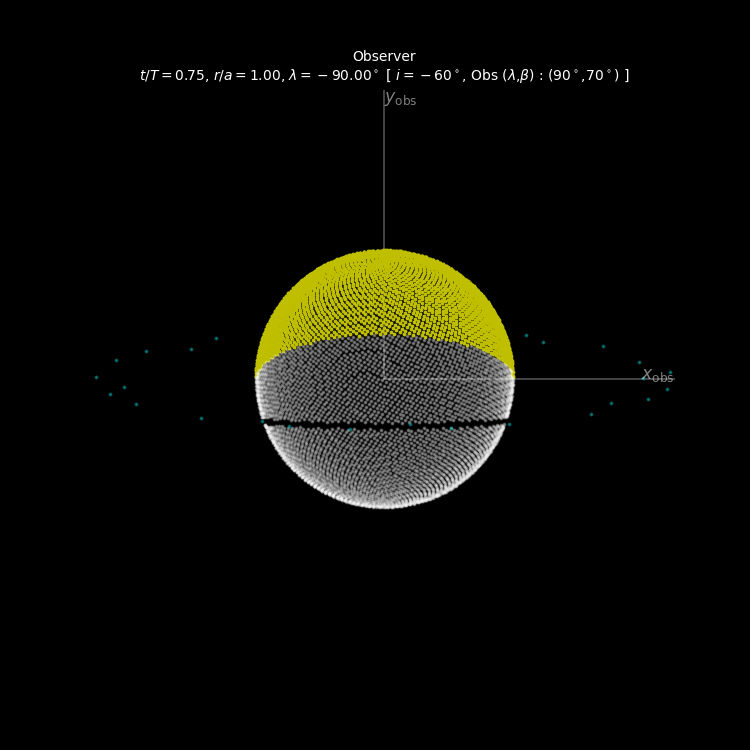

In [426]:
obs_fig

Now calculate:

In [427]:
# Make lists
Stot  = []
Sp    = []
Sr    = []
Ptot  = []
Pp    = []
Pr    = []
alpha = []
vorbit= []
rstar = []
rstaro= []

print("\n########################################")
start_msg = f" Starting orbit simulation with: \n fou_file_planet = {RP.fname_planet} ,"+\
            f"\n fou_file_ring = {RP.fname_ring} ,"+\
            f"\n orbit inclination = {iorb} ,"+\
            f"\n ring roll = {alphar} ,"+\
            f"\n ring inclination = {gamma} ,"+\
            f"\n ring ri = {RP.fi} ,"+\
            f"\n ring re = {RP.fe} ,"+\
            f"\n observer i = {RP.eobs_ecl[1]/Consts.deg} ,"+\
            f"\n observer longitude = {RP.eobs_ecl[0]/Consts.deg} ,"+\
            f"\n ring inclination wrt ecl = {RP.i/Consts.deg} ,"+\
            f"\n number of ring spangles = {RP.Nrt} ,"+\
            f"\n number of planet spangles = {RP.Np} ,"+\
            f"\n ring opacity = {tau_ring} , "+\
            f"\n reference plane = {RP.reference_plane} "
print(start_msg)
print("########################################\n")

# Start the orbit
for lamb in tqdm(lambs):
    RP.changeStellarPosition(lamb)
    #print("True anomaly: ", (lamb-lamb_initial)/Consts.deg)
    RP.updateSpangles()
    RP.updateReflection(taur=tau_ring,normalize=normalize)
    #print("used ring opacity: ", RP.taur)

    # Save the relevant data
    Stot  += [RP.Stot]
    Sp    += [RP.Stotp]
    Sr    += [RP.Stotr]
    Ptot  += [RP.Ptot]
    Pp    += [RP.Ptotp]
    Pr    += [RP.Ptotr]
    alpha += [np.arccos(RP.alphaps)/Consts.deg]
    vorbit+= [RP.vorbit]
    rstar += [RP.rstar]
    rstaro+= [RP.rstar_obs]

true_anomaly = list((lambs-lamb_initial)/Consts.deg)

# Get the key quantities
alpha = np.array(alpha)
Sp = np.array(Sp)
Pflux = np.sqrt(Sp[:,1]**2 + Sp[:,2]**2)
Pp = np.array(Pp)
flux = Sp[:,0]


########################################
 Starting orbit simulation with: 
 fou_file_planet = tmp/fou_bmsca10.0_asurf0.5.dat ,
 fou_file_ring = tmp/fou_ring_0_4_0_8.dat ,
 orbit inclination = 20 ,
 ring roll = [] ,
 ring inclination = 80 ,
 ring ri = 2.0 ,
 ring re = 2.25 ,
 observer i = 70.00000020649223 ,
 observer longitude = 90.0000001836389 ,
 ring inclination wrt ecl = -59.999999931439994 ,
 number of ring spangles = 29 ,
 number of planet spangles = 12000 ,
 ring opacity = 0.0 , 
 reference plane = Detector 
########################################



100%|██████████| 361/361 [00:41<00:00,  8.71it/s]


Now plot it:

<IPython.core.display.Javascript object>


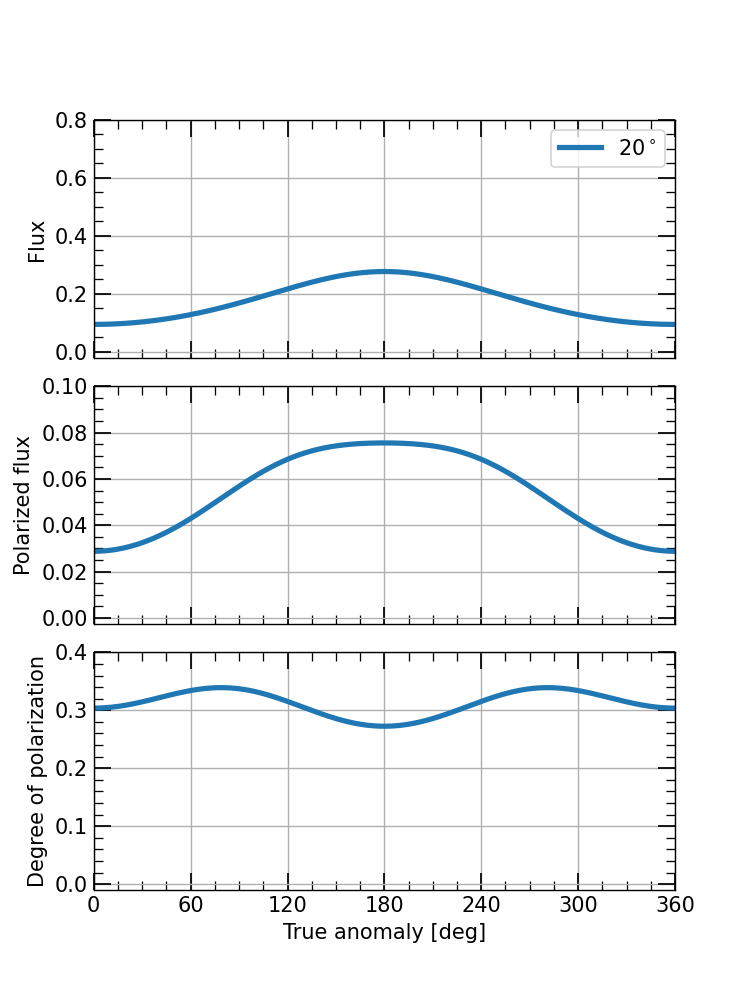

Saving figures/Orbit_incl_test.png...


In [428]:
notext = False

fsize = 2
fig = plt.figure(figsize=(3*fsize,4*fsize))

plt.rcParams.update({'font.size': 6*fsize})
gs = fig.add_gridspec(3, hspace=0.12)
axs = gs.subplots(sharex=True)

plot_line = ["-","--","-.",":",(0, (3, 1, 1, 1, 1, 1))]

ii = 0
axs[0].plot(true_anomaly,flux,linestyle=plot_line[ii],label=f"{iorb}$^\circ$",linewidth=3)
axs[1].plot(true_anomaly,Pflux,linestyle=plot_line[ii],label=f"Inclination {iorb}",linewidth=3)
axs[2].plot(true_anomaly,abs(Pp),linestyle=plot_line[ii],label=f"Inclination {iorb}",linewidth=3)
    
axs[0].legend()
axs[0].grid()
axs[1].grid()
axs[2].grid()
    
setup_plot(axs[0],60,0,360,0.2,-0.02,0.8,notext=notext)
setup_plot(axs[1],60,0,360,0.02,-0.0025,0.1,notext=notext)
setup_plot(axs[2],60,0,360,0.1,-0.01,0.4,notext=notext)
axs[0].set_ylabel("Flux")
axs[1].set_ylabel("Polarized flux")
axs[2].set_ylabel("Degree of polarization")
axs[2].set_xlabel("True anomaly [deg]")

fig.tight_layout()
save_figure(fig,"Orbit_incl_test", fig_dir=fig_dir, dpi=300, formats=["png"])

We need to generalize the previous procedure in order to change orbital inclination and any other parameter of the simularion. For that purpose we will create a general routine:

In [571]:
def simulation(iorb: float):
    
    # Constant parameters
    name = f"Orbit_incl80_fix"
    value = iorb
    
    tini = time.time()
    print(f"Simulating for iorb = {iorb}...")
    logfile = open(tmp_dir + f"logfile-{iorb}.out", "w")

    #Parameters
    fou_file_ring = tmp_dir + "fou_ring_0_4_0_8.dat"
    fou_file_planet = tmp_dir + "fou_bmsca10.0_asurf0.5.dat"

    # Though ring is transparent we must provide options
    tau_ring = 0.0 # Ring is transparent
    ring_ri = 2.0
    ring_re = 2.25
    gamma = 80 # Ring inclination
    alphar = 0 # Ring roll

    # Scattering options
    interp = "spline"
    reference_plane = "Detector"

    # Number of spangles
    Ns = 30
    Nb = 0
    Np = 12000
    Nr = 100

    # Other parameters
    a = 1
    r_s = Consts.rsun
    r_p = Consts.rsaturn
    e = 0.0
    theta_end = 360
    n_theta = 361
    allow_non_uni = False
    normalize = True
    lambq_offset = 0.0
    limb_coeffs = [0.65]
    interpr = "spline"
    
    # Make sure all output is printed
    pr.Verbose.VERBOSITY=pr.VERB_NONE

    # Calculate starting position of observer and star
    ir, beta_obs, lamb_obs, lamb_star = pr.Util.calcStartingPosition(iorb,gamma,alphar)
    print(f"Initial conditions in the planet-centered system are:")
    print(f"\tRing inclination w.r.t. ecliptic: {ir*Consts.rad:.1f} deg")
    print(f"\tInclination of the observer w.r.t ecliptic: {beta_obs*Consts.rad:.1f} deg")
    print(f"\tInitial longitude of the observer: {lamb_obs*Consts.rad:.1f} deg")
    print(f"\tInitial longitude of the star: {lamb_star*Consts.rad:.1f} deg")

    # Intialize system
    sys = pr.System()
    s=sys.add(kind="Star",physics=dict(radius=r_s/sys.ul),optics=dict(limb_coeffs=limb_coeffs))
    p=sys.add(kind="Planet", primary=s,
                   radius=r_p/sys.ul,
                   orbit=dict(a=a, e=e),
                   physics=dict(radius=r_p/sys.ul),
                   optics=dict(nspangles=Np))
    r=sys.add(kind="Ring", primary=p,
                   physics=dict(fi=ring_ri, fe=ring_re, i=ir),
                   optics=dict(nspangles=Nr))
    RP=sys.ensamble_system(extension=extension,
                           fname_planet=fou_file_planet,
                           fname_ring=fou_file_ring)
    RP.behavior["interp_method_ring"] = interpr
    RP.behavior["allow_non_uni"] = allow_non_uni
    RP.reference_plane = reference_plane

    # Now we will prepare the interval of longitudes and see the configuration:
    lamb_initial = lamb_star
    lamb_final = lamb_initial + theta_end*Consts.deg
    lambs = np.linspace(lamb_initial,lamb_final,n_theta)

    # Determine starting position in eccentric orbit, default is apocenter
    if e >= 0.05:
        lq = np.linspace(0,2*np.pi,2000)
        d_max = 0
        lambq_max = 0
        for ii,l in enumerate(lq):
            RP.lambq = l
            RP.changeStellarPosition(lamb_initial)
            d = RP.rstar
            if d >= d_max:
                d_max = d
                lambq_max = l
        RP.lambq = lambq_max + lambq_offset*np.pi/180     

    # Initialise the starting position
    RP.changeObserver([lamb_obs,beta_obs])
    RP.changeStellarPosition(lamb_initial)
    RP.updateSpangles()

    # Save images showing the starting position of planet, ring and star
    ecl_fig,obs_fig,star_fig = RP.plotRingedPlanet(showstar=True,showfig=False)
    for rf in "ecl","obs","star":
        fig=eval(f"{rf}_fig")
        save_figure(fig,f"fig_with_{name}_{value}_and_oi_{iorb}_rl_{alphar}_ri_{gamma}_rin_{ring_ri}_rout_{ring_re}_{rf}",
                    fig_dir=fig_dir, dpi=300, formats=["png"],quiet=True)

    # Simulate
    Stot  = []
    Sp    = []
    Sr    = []
    Ptot  = []
    Pp    = []
    Pr    = []
    alpha = []
    vorbit= []
    rstar = []
    rstaro= []

    print("\n########################################")
    start_msg = f" Starting orbit simulation with: \n fou_file_planet = {RP.fname_planet} ,"+\
                f"\n fou_file_ring = {RP.fname_ring} ,"+\
                f"\n orbit inclination = {iorb} ,"+\
                f"\n ring roll = {alphar} ,"+\
                f"\n ring inclination = {gamma} ,"+\
                f"\n ring ri = {RP.fi} ,"+\
                f"\n ring re = {RP.fe} ,"+\
                f"\n observer i = {RP.eobs_ecl[1]/Consts.deg} ,"+\
                f"\n observer longitude = {RP.eobs_ecl[0]/Consts.deg} ,"+\
                f"\n ring inclination wrt ecl = {RP.i/Consts.deg} ,"+\
                f"\n number of ring spangles = {RP.Nrt} ,"+\
                f"\n number of planet spangles = {RP.Np} ,"+\
                f"\n ring opacity = {tau_ring} , "+\
                f"\n reference plane = {RP.reference_plane} "
    print(start_msg)
    print("########################################\n")

    # Start the orbit
    for lamb in lambs:
        RP.changeStellarPosition(lamb)
        #print("True anomaly: ", (lamb-lamb_initial)/Consts.deg)
        RP.updateSpangles()
        RP.updateReflection(taur=tau_ring,normalize=normalize)
        #print("used ring opacity: ", RP.taur)

        # Save the relevant data
        Stot  += [RP.Stot]
        Sp    += [RP.Stotp]
        Sr    += [RP.Stotr]
        Ptot  += [RP.Ptot]
        Pp    += [RP.Ptotp]
        Pr    += [RP.Ptotr]
        alpha += [np.arccos(RP.alphaps)/Consts.deg]
        vorbit+= [RP.vorbit]
        rstar += [RP.rstar]
        rstaro+= [RP.rstar_obs]

    true_anomaly = list((lambs-lamb_initial)/Consts.deg)

    # Save the output to a pickle file for revovery after running 
    parameters = {"Fourier planet": RP.fname_planet, "Fourier ring": RP.fname_ring,
                  "Orbit inclinatie": iorb, "Ring roll": alphar,
                  "Ring inclination": ir, "Ring ri": RP.fi, "Ring re": RP.fe,
                  "Observer inclination": RP.eobs_ecl[1]/Consts.deg, 
                  "Observer longitude": RP.eobs_ecl[0]/Consts.deg,
                  "Ring i_ecl": RP.i/Consts.deg,
                  "Nr": RP.Nrt,
                  "Np": RP.Np,
                  "Ring opacity": tau_ring,
                  "Ref plane": RP.reference_plane,
                  "Planet radius": RP.Rp}
    save_dict = {"lambda": true_anomaly, "alpha": alpha, "Stot": Stot,
                 "Sp": Sp, "Sr": Sr, "Ptot": Ptot, "Pp": Pp, "Pr": Pr,
                 "vorbit": vorbit, "rstar": rstar, "rstar_obs": rstaro,
                 "Param": parameters}

    # Pickle the data, if file already exists it will be overwritten
    with open(tmp_dir + f"data_with_{name}_{value}.pkl", "wb") as f:
        pickle.dump(save_dict, f)

    tend = time.time()
    print(f"End simulating for iorb = {iorb} (exectution time {tend-tini} seconds)...")

In [551]:
simulation(iorbs[0])

Simulating for iorb = 0...
End simulating for iorb = 0 (exectution time 57.66486597061157 seconds)...


Now we need to devise a routine to plot the result of a simulation using the pickle results:

<IPython.core.display.Javascript object>


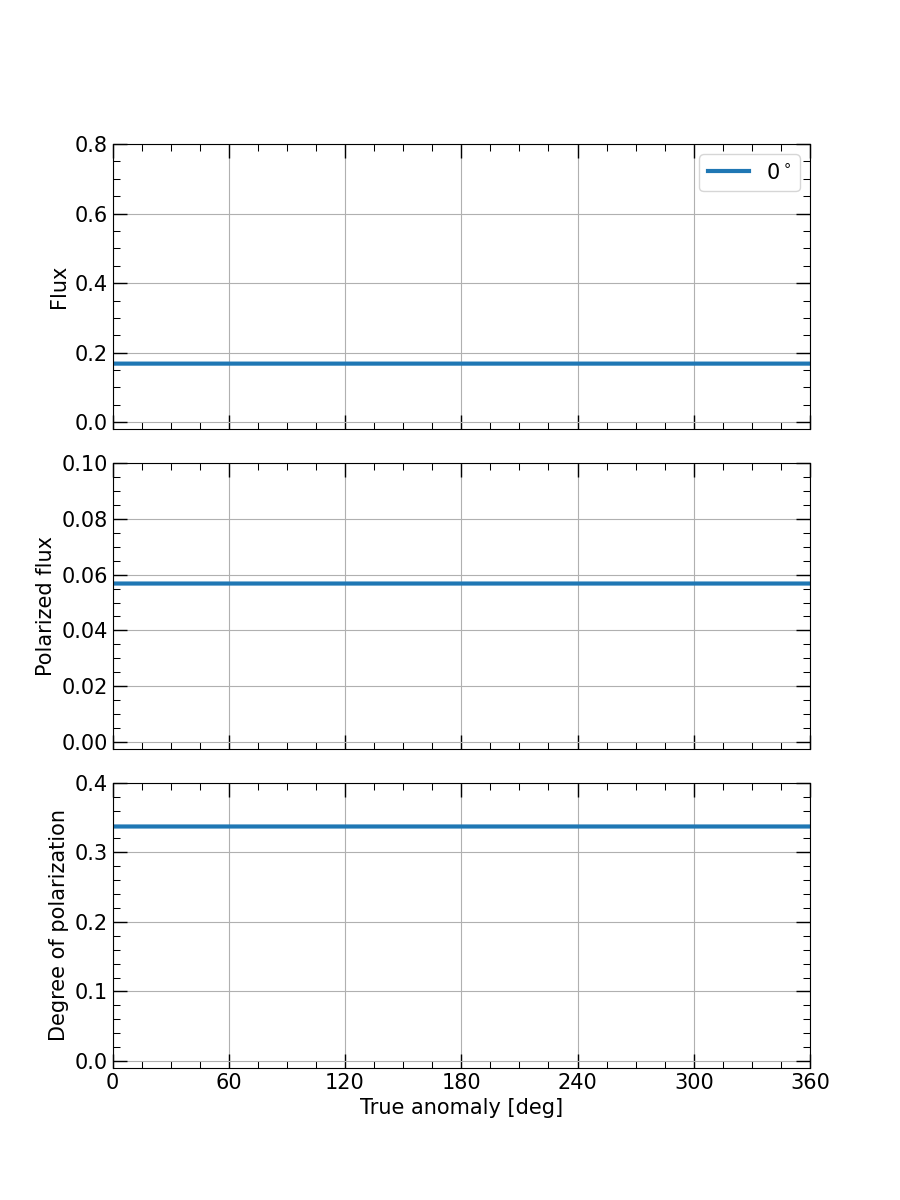

Saving figures/Orbit_incl.png...
Saving figures/Orbit_incl.svg...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving figures/Orbit_incl.eps...


In [552]:
iorbs = [iorbs[0]]

name = "Orbit_incl80_fix"

notext = False
fig = plt.figure(figsize=(9,12))
gs = fig.add_gridspec(3, hspace=0.12)
axs = gs.subplots(sharex=True)

plot_line = ["-","--","-.",":",(0, (3, 1, 1, 1, 1, 1))]
for ii, iorb in enumerate(iorbs):
    data_name = tmp_dir + f"data_with_{name}_{iorb}.pkl"

    with open(data_name,"rb") as f:
        save_file = pickle.load(f)

    true_anomaly = np.array(save_file["lambda"])
    alpha = np.array(save_file["alpha"])
    Sp = np.array(save_file["Sp"])
    Pflux = np.sqrt(Sp[:,1]**2 + Sp[:,2]**2)
    Pp = np.array(save_file["Pp"])
    flux = Sp[:,0]
    
    """
    if iorb == 90:
        Rip = np.array(save_file["Rip"])
        tp = np.array(save_file["tp"])
        ip = np.array(save_file["ip"])
        vp = np.array(save_file["vp"])
    """
        
    axs[0].plot(true_anomaly,flux,linestyle=plot_line[ii],label=f"{iorb}$^\circ$",linewidth=3)
    axs[1].plot(true_anomaly,Pflux,linestyle=plot_line[ii],label=f"Inclination {iorb}",linewidth=3)
    axs[2].plot(true_anomaly,abs(Pp),linestyle=plot_line[ii],label=f"Inclination {iorb}",linewidth=3)
    if ii == 8:
        notext = True
    
axs[0].legend()
axs[0].grid()
axs[1].grid()
axs[2].grid()
    
setup_plot(axs[0],60,0,360,0.2,-0.02,0.8,notext=notext)
setup_plot(axs[1],60,0,360,0.02,-0.0025,0.1,notext=notext)
setup_plot(axs[2],60,0,360,0.1,-0.01,0.4,notext=notext)
axs[0].set_ylabel("Flux")
axs[1].set_ylabel("Polarized flux")
axs[2].set_ylabel("Degree of polarization")
axs[2].set_xlabel("True anomaly [deg]")

save_figure(fig,"Orbit_incl", fig_dir=fig_dir, dpi=300)

Now we can run several orbital inclinations using `joblib`

In [573]:
#Options to Parallel: https://joblib.readthedocs.io/en/stable/generated/joblib.Parallel.html
iorbs = np.array([0,10,20,30,40,50,60,70,80,90])
backend='loky'
#backend='sequential'
tini=time.time()
Parallel(n_jobs=4,backend=backend,verbose=50)(delayed(simulation)(iorb) for iorb in iorbs)
tend=time.time()
print(f"Parallel execution time = {tend-tini}")

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done   4 out of  10 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:  2.1min remaining:  1.4min
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  2.2min remaining:   55.5s
[Parallel(n_jobs=4)]: Done   8 out of  10 | elapsed:  2.4min remaining:   35.4s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  3.1min finished
Parallel execution time = 186.4676399230957


Now we can plot them all:

<IPython.core.display.Javascript object>


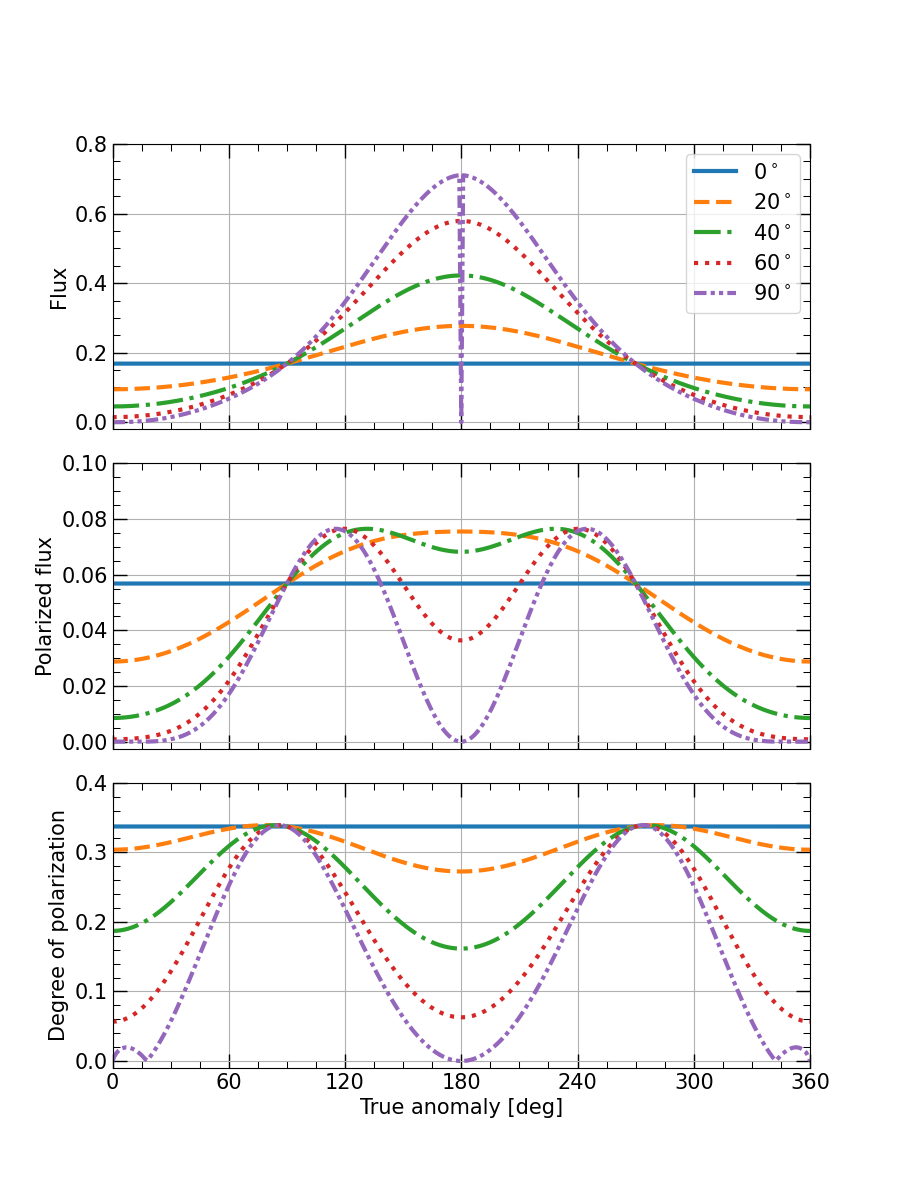

Saving figures/Orbit_incl.png...
Saving figures/Orbit_incl.svg...


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving figures/Orbit_incl.eps...


In [576]:
iorbs = np.array([0,20,40,60,90])

name = "Orbit_incl80_fix"

notext = False
fig = plt.figure(figsize=(9,12))
gs = fig.add_gridspec(3, hspace=0.12)
axs = gs.subplots(sharex=True)

plot_line = ["-","--","-.",":",(0, (3, 1, 1, 1, 1, 1))]
for ii, iorb in enumerate(iorbs):
    data_name = tmp_dir + f"data_with_{name}_{iorb}.pkl"

    with open(data_name,"rb") as f:
        save_file = pickle.load(f)

    true_anomaly = np.array(save_file["lambda"])
    alpha = np.array(save_file["alpha"])
    Sp = np.array(save_file["Sp"])
    Pflux = np.sqrt(Sp[:,1]**2 + Sp[:,2]**2)
    Pp = np.array(save_file["Pp"])
    flux = Sp[:,0]
    
    axs[0].plot(true_anomaly,flux,linestyle=plot_line[ii],label=f"{iorb}$^\circ$",linewidth=3)
    axs[1].plot(true_anomaly,Pflux,linestyle=plot_line[ii],label=f"Inclination {iorb}",linewidth=3)
    axs[2].plot(true_anomaly,abs(Pp),linestyle=plot_line[ii],label=f"Inclination {iorb}",linewidth=3)
    if ii == 8:
        notext = True
    
axs[0].legend()
axs[0].grid()
axs[1].grid()
axs[2].grid()
    
setup_plot(axs[0],60,0,360,0.2,-0.02,0.8,notext=notext)
setup_plot(axs[1],60,0,360,0.02,-0.0025,0.1,notext=notext)
setup_plot(axs[2],60,0,360,0.1,-0.01,0.4,notext=notext)
axs[0].set_ylabel("Flux")
axs[1].set_ylabel("Polarized flux")
axs[2].set_ylabel("Degree of polarization")
axs[2].set_xlabel("True anomaly [deg]")

save_figure(fig,"Orbit_incl", fig_dir=fig_dir, dpi=300)

Or we can use `mp`:

In [471]:
if __name__ == '__main__':
    params = []
    for iorb in iorbs:
        params.append([iorb])
    pool_handler(len(params),params,simulation,1)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/jorgezuluagacallejas/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/jorgezuluagacallejas/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'simulation' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/jorgezuluagacallejas/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/jorgezuluagacallejas/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'simulation' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1

## Figure 5: Ring model ($i = 20^\circ$)

Now we want to study the polarization including a ring.

Get datafiles required:

In [577]:
files=["fou_ring_0_4_0_8.dat","fou_bmsca10.0_asurf0.5.dat"]
pr.Misc.retrieve(files,path=tmp_dir,overwrite=False,quiet=False)

Index file tmp//pryngles_data_index.csv already retrieved. For overwrite use overwrite = True.
There are 138 files in data repository.
File tmp//fou_ring_0_4_0_8.dat already retrieved. For overwrite use overwrite = True.
File tmp//fou_bmsca10.0_asurf0.5.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_0_4_0_8.dat', 'tmp//fou_bmsca10.0_asurf0.5.dat']


['tmp//fou_ring_0_4_0_8.dat', 'tmp//fou_bmsca10.0_asurf0.5.dat']

Parameter for our numerical experiment:

In [578]:
fou_file_ring = tmp_dir + "fou_ring_0_4_0_8.dat"
fou_file_planet = tmp_dir + "fou_bmsca10.0_asurf0.5.dat"

# Range of orbital inclinations to explore
iorbs = np.array([20,90]) # Orbital inclinations
gammas = np.array([0,30,60,90]) # Ring inclinations
alphars = np.array([0,30,60,90]) # Ring rolla angle

# Though ring is transparent we must provide options
tau_ring = 0.4 # Ring is opaque
ring_ri = 1.2
ring_re = 2.25

# Scattering options
interpr = "spline"
reference_plane = "Detector"

# Number of spangles
Ns = 30
Nb = 0
Np = 10000
Nr = 10000

Let's run a single simulation:

In [585]:
# Make sure all output is printed
pr.Verbose.VERBOSITY=pr.VERB_NONE
iorb = iorbs[0]
alphar = alphars[1]
gamma = gammas[2]

# Calculate starting position of observer and star
ir, beta_obs, lamb_obs, lamb_star = pr.Util.calcStartingPosition(iorb,gamma,alphar)
print(f"Initial conditions in the planet-centered system are:")
print(f"\tRing inclination w.r.t. ecliptic: {ir*Consts.rad:.1f} deg")
print(f"\tInclination of the observer w.r.t ecliptic: {beta_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the observer: {lamb_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the star: {lamb_star*Consts.rad:.1f} deg")

Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 45.3 deg
	Inclination of the observer w.r.t ecliptic: 70.0 deg
	Initial longitude of the observer: -69.4 deg
	Initial longitude of the star: 110.6 deg


Define the system:

In [586]:
sys = pr.System()
s=sys.add(kind="Star",physics=dict(radius=Consts.rsun/sys.ul),optics=dict(limb_coeffs=[0.65]))
p=sys.add(kind="Planet", primary=s,
          radius=Consts.rsaturn/sys.ul,
          orbit=dict(a=1.0, e=0.0),
          physics=dict(radius=Consts.rsaturn/sys.ul),
          optics=dict(nspangles=Np))
r=sys.add(kind="Ring", primary=p,
          physics=dict(fi=ring_ri, fe=ring_re, i=ir),
          optics=dict(nspangles=Nr))

RP=sys.ensamble_system(extension=extension,
                       fname_planet=fou_file_planet,
                       fname_ring=fou_file_ring)

RP.behavior["interp_method_ring"] = interpr
RP.reference_plane = reference_plane

Before integrating, reinitilizate system:

In [587]:
# Re-initialise the system for a different ring inclination
ir, beta_obs, lamb_obs, lamb_star = pr.Util.calcStartingPosition(iorb,gamma,alphar)
RP.i = ir
RP.changeObserver([lamb_obs,beta_obs])
RP.Ns = Ns
RP.Np = Np
RP.Nr = Nr
RP.Nb = Nb
RP.updateProperties()

Prepare orientation:

In [588]:
lamb_initial = lamb_star
lamb_final = lamb_initial + 360*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,361)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP.updateSpangles()

# Save images showing the starting position of planet, ring and star
ecl_fig,obs_fig,star_fig = RP.plotRingedPlanet(showstar=False,showfig=False,showtitle=False,axis=False)
for rf in "ecl","obs","star":
    fig=eval(f"{rf}_fig")
    save_figure(fig,f"fig_with_oi_{iorb}_rl_{alphar}_ri_{gamma}_{rf}",
                fig_dir=fig_dir, dpi=300, formats=["png"])

Saving figures/fig_with_oi_20_rl_30_ri_60_ecl.png...
Saving figures/fig_with_oi_20_rl_30_ri_60_obs.png...
Saving figures/fig_with_oi_20_rl_30_ri_60_star.png...


Create light-curve:

In [589]:
# Make lists
Stot  = []
Sp    = []
Sr    = []
Ptot  = []
Pp    = []
Pr    = []
alpha = []

# Start the orbit
for lamb in tqdm(lambs):
    RP.changeStellarPosition(lamb)
    RP.updateSpangles()
    RP.updateReflection(taur=tau_ring)

    # Save the relevant data
    Stot  += [RP.Stot]
    Sp    += [RP.Stotp]
    Sr    += [RP.Stotr]
    Ptot  += [RP.Ptot]
    Pp    += [RP.Ptotp]
    Pr    += [RP.Ptotr]
    alpha += [np.arccos(RP.alphaps)/Consts.deg]

true_anomaly = list((lambs-lamb_initial)/Consts.deg)

# Get the key quantities
alpha = np.array(alpha)
Stot = np.array(Stot)
Pflux = np.sqrt(Stot[:,1]**2 + Stot[:,2]**2)
Ptot = np.array(Ptot)
flux = Stot[:,0]

100%|██████████| 361/361 [00:57<00:00,  6.32it/s]


Plot the result:

<IPython.core.display.Javascript object>


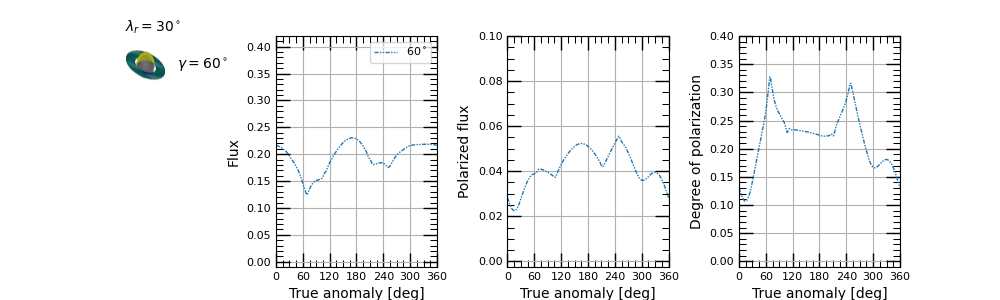

Saving figures/Geom_orbit_test-alphar_30-gamma_60.png...


In [591]:
notext = True
kk=0
plot_line = [(0, (3, 1, 1, 1, 1, 1)),"--","-.",":"]
sub_plot_loc = [0.75,0.5,0.25,0.0]

#Create figure
fsize=1
plt.rcParams.update({'font.size': 8*fsize})
notext = True
fig = plt.figure(figsize=(10*fsize,3*fsize))
gs = fig.add_gridspec(ncols=4, nrows=1, hspace=0.12, wspace = 0.5, width_ratios= [0.5,1,1,1])
axs = gs.subplots(sharex=True)

#Add preview of configuration
figure_loc = fig_dir + f"fig_with_oi_{iorb}_rl_{alphar}_ri_{gamma}_obs.png"
subpos = [0.0,sub_plot_loc[kk],0.5,0.25]
subax1 = add_subplot_axes(axs[0],subpos)
figure = cv.imread(figure_loc)
b, g, r = cv.split(figure)
tmp = cv.cvtColor(figure, cv.COLOR_BGR2GRAY)
_,alp = cv.threshold(tmp,0,255,cv.THRESH_BINARY)
rgba = [r,g,b, alp]
figure = cv.merge(rgba,4)
scale_percent = 80
width = int(figure.shape[1] * scale_percent / 100)
height = int(figure.shape[0] * scale_percent / 100)
dim = (width,height)
resized = cv.resize(figure, dim, interpolation = cv.INTER_AREA)
subax1.imshow(resized, interpolation='bicubic', aspect='auto')
subax1.text(0.0, 1.15, f'$\lambda_r = {alphar}^\circ$',
                {'fontsize': 10*fsize}, horizontalalignment='left',
                verticalalignment='center', transform=subax1.transAxes)
subax1.text(1.3, 0.5, f'$\gamma = {gamma}^\circ$', {'fontsize': 10*fsize},
            horizontalalignment='left', verticalalignment='center', 
            transform=subax1.transAxes)
subax1.set_axis_off()
axs[0].set_axis_off()

#Plot figures
axs[1].plot(true_anomaly,flux,linestyle=plot_line[kk],label=f"{gamma}$^\circ$",linewidth=1*fsize)
axs[2].plot(true_anomaly,Pflux,linestyle=plot_line[kk],label=f"Inclination {gamma}",linewidth=1*fsize)
axs[3].plot(true_anomaly,abs(Ptot),linestyle=plot_line[kk],label=f"Inclination {gamma}",linewidth=1*fsize)
axs[1].legend()

axs[1].set_ylabel("Flux",fontsize=10*fsize)
axs[2].set_ylabel("Polarized flux",fontsize=10*fsize)
axs[3].set_ylabel("Degree of polarization",fontsize=10*fsize)

setup_plot(axs[1],60,0,360,0.05,-0.01,0.42,notext=notext)
setup_plot(axs[2],60,0,360,0.02,-0.0025,0.1,notext=notext)
setup_plot(axs[3],60,0,360,0.05,-0.01,0.4,notext=notext)

for ax in axs[1:]:
    ax.grid()
    ax.set_xlabel("True anomaly [deg]",fontsize=10)

#fig.tight_layout()
save_figure(fig,f"Geom_orbit_test-alphar_{alphar}-gamma_{gamma}", fig_dir=fig_dir, dpi=300, formats=['png'])

--- 
*The authors*, Last update: june 19, 2023.